# Finance Data Mining: K-Means Clustering + KNN Classification

This notebook implements the complete workflow:
1. **Part 1 (K-Means)**: Discover customer segments using unsupervised clustering
2. **Part 2 (KNN)**: Train a classifier to predict segments for new customers

---
# Part 1: K-Means Clustering

In [3]:
import sys
import os

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from modules.tool_kmeans import run_kmeans, find_optimal_k

In [4]:
# Load Finance Dataset
dataset = pd.read_csv("../../data/finance-data.csv")
print(f"Dataset shape: {dataset.shape}")
dataset.head()

Dataset shape: (8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Data Cleaning and Feature Engineering

In [5]:
# Clean the dataset before adding new features
clean_ds = dataset.drop(['CUST_ID'], axis=1).copy()
clean_ds = clean_ds.dropna()

# Feature Engineering
clean_ds['BALANCE_USAGE_RATIO'] = clean_ds['BALANCE'] / clean_ds['CREDIT_LIMIT']
clean_ds['ONEOFF_PURCHASE_RATIO'] = clean_ds['ONEOFF_PURCHASES'] / clean_ds['PURCHASES']
clean_ds['INSTALLMENT_PURCHASE_RATIO'] = clean_ds['INSTALLMENTS_PURCHASES'] / clean_ds['PURCHASES']
clean_ds['TOTAL_PURCHASES'] = clean_ds['ONEOFF_PURCHASES'] + clean_ds['INSTALLMENTS_PURCHASES']
clean_ds['PURCHASES_PER_TRX'] = clean_ds['PURCHASES'] / clean_ds['PURCHASES_TRX']
clean_ds['CASH_ADVANCE_PER_TRX'] = clean_ds['CASH_ADVANCE'] / clean_ds['CASH_ADVANCE_TRX']
clean_ds['PAYMENT_RATIO'] = clean_ds['PAYMENTS'] / clean_ds['CREDIT_LIMIT']
clean_ds['UTILIZATION_RATIO'] = (clean_ds['PURCHASES'] + clean_ds['CASH_ADVANCE']) / clean_ds['CREDIT_LIMIT']
clean_ds['FULL_PAYMENT_FLAG'] = (clean_ds['PRC_FULL_PAYMENT'] > 0.8).astype(int)

# Handle division by zero: replace NaN and inf values with 0
clean_ds = clean_ds.fillna(0)
clean_ds = clean_ds.replace([np.inf, -np.inf], 0)

print(f"Clean dataset shape: {clean_ds.shape}")
print(f"Missing values: {clean_ds.isnull().sum().sum()}")

Clean dataset shape: (8636, 26)
Missing values: 0


## Find Optimal K (Elbow Method)

✓ Elbow plot saved as 'elbow_method.png'


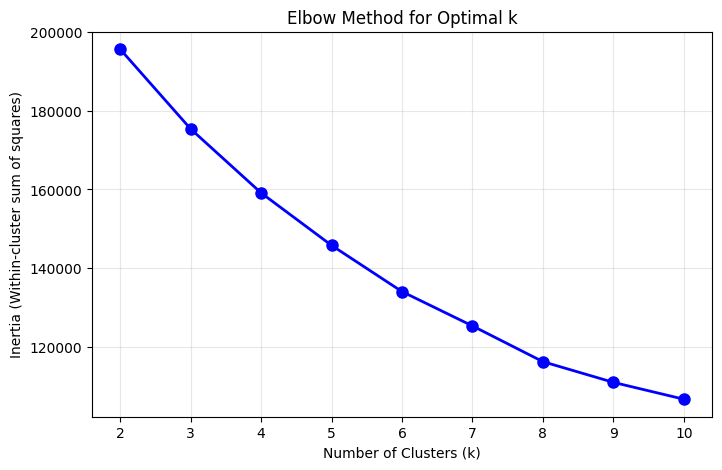


Optimal K (from elbow method): 2


In [6]:
# Create a copy with dummy target column for the tool
ds_for_analysis = clean_ds.copy()
ds_for_analysis['_DUMMY_'] = 0

# Find optimal K using elbow method
elbow_results = find_optimal_k(ds_for_analysis, target_column='_DUMMY_', k_range=range(2, 11))

# Find optimal k from elbow results
k_values_list = list(elbow_results.keys())
inertias = list(elbow_results.values())
diffs = [inertias[i] - inertias[i+1] for i in range(len(inertias)-1)]
optimal_k = k_values_list[np.argmax(diffs)]
print(f"\nOptimal K (from elbow method): {optimal_k}")

## Apply K-Means Clustering


K-MEANS CLUSTERING ANALYSIS

✓ Dropped target column: '_DUMMY_'
✓ Number of features: 26
✓ Number of samples: 8636
✓ Applied StandardScaler to normalize features
✓ K-Means fitted with 2 clusters

CLUSTERING RESULTS

Cluster Distribution:
  Cluster 0: 4482 samples (51.9%)
  Cluster 1: 4154 samples (48.1%)

Cluster Centers (Scaled Values):
           BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  BALANCE_USAGE_RATIO  ONEOFF_PURCHASE_RATIO  INSTALLMENT_PURCHASE_RATIO  TOTAL_PURCHASES  PURCHASES_PER_TRX  CASH_ADVANCE_PER_TRX  PAYMENT_RATIO  UTILIZATION_RATIO  FULL_PAYMENT_FLAG
Cluster 0    0.209             -0.058     -0.333            -0.210                  -0.402         0.307               -0.785                      -0.291          

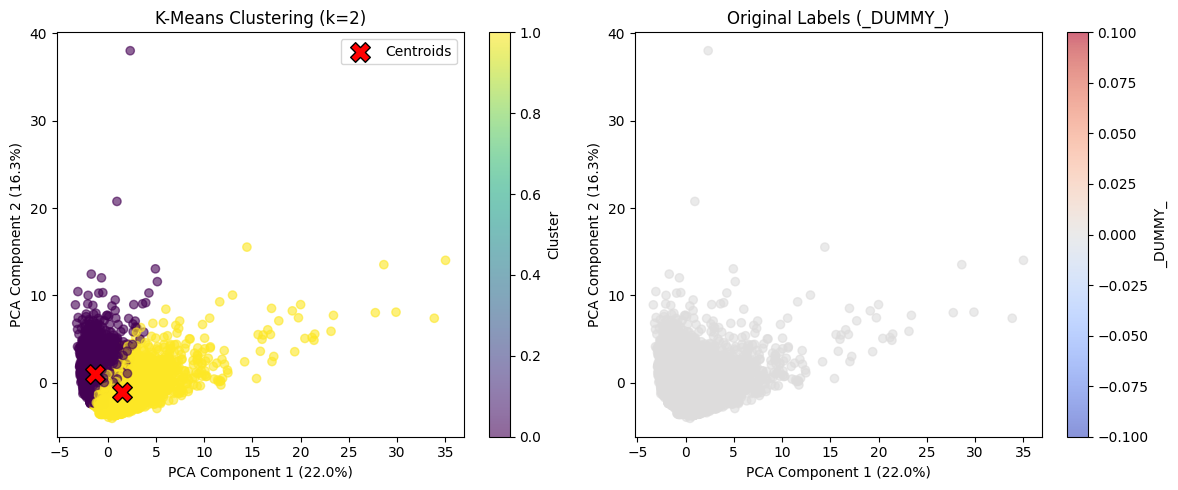


✓ Cluster labels added to dataset for KNN classification
✓ Shape of clean_ds: (8636, 27)
✓ Cluster distribution:
Cluster
0    4482
1    4154
Name: count, dtype: int64


In [7]:
# Create a copy with dummy target column for the tool
ds_for_clustering = clean_ds.copy()
ds_for_clustering['_DUMMY_'] = 0

# Run K-Means with optimal K
cluster_labels, cluster_centers, kmeans_model = run_kmeans(
    ds_for_clustering, 
    target_column='_DUMMY_', 
    n_clusters=optimal_k, 
    visualize=True
)

# Add cluster labels to original dataset - these become our target labels for KNN
clean_ds['Cluster'] = cluster_labels

print(f"\n✓ Cluster labels added to dataset for KNN classification")
print(f"✓ Shape of clean_ds: {clean_ds.shape}")
print(f"✓ Cluster distribution:\n{clean_ds['Cluster'].value_counts().sort_index()}")

---
# Part 2: KNN Classification

Now that we have cluster labels from K-Means, we can train a KNN classifier to predict segments for new customers.

In [8]:
# Additional imports for KNN
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Step 2: Prepare Data for KNN Classification

In [9]:
# Separate features and target (the cluster labels from K-Means)
feature_cols = [col for col in clean_ds.columns if col not in ['Cluster']]
X_knn = clean_ds[feature_cols].copy()
y_knn = clean_ds['Cluster'].copy()  # These are the labels K-Means created!

print(f"Features for KNN: {X_knn.shape}")
print(f"Target variable (from K-Means): {y_knn.shape}")
print(f"Unique clusters: {sorted(y_knn.unique())}")

Features for KNN: (8636, 26)
Target variable (from K-Means): (8636,)
Unique clusters: [np.int32(0), np.int32(1)]


## Step 3: Split into Train and Test Sets

In [10]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_knn, y_knn, test_size=0.2, random_state=42, stratify=y_knn
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (6908, 26)
Test set: (1728, 26)


## Step 4: Scale Features for KNN

In [11]:
# KNN is distance-based, so scaling is crucial
scaler_knn = StandardScaler()
X_train_scaled = scaler_knn.fit_transform(X_train)
X_test_scaled = scaler_knn.transform(X_test)

print("✓ Features scaled using StandardScaler")

✓ Features scaled using StandardScaler


## Step 5: Find Optimal K (Number of Neighbors)

In [12]:
# Test different values of K to find the best one
k_values = range(3, 31)
train_scores = []
test_scores = []
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    train_scores.append(knn.score(X_train_scaled, y_train))
    test_scores.append(knn.score(X_test_scaled, y_test))
    cv_scores.append(cross_val_score(knn, X_train_scaled, y_train, cv=5).mean())

# Find optimal K
optimal_k_knn = list(k_values)[np.argmax(test_scores)]
print(f"Optimal K for KNN: {optimal_k_knn}")
print(f"Best test accuracy: {max(test_scores):.4f}")

Optimal K for KNN: 8
Best test accuracy: 0.9751


✓ Plot saved as 'knn_optimal_k.png'


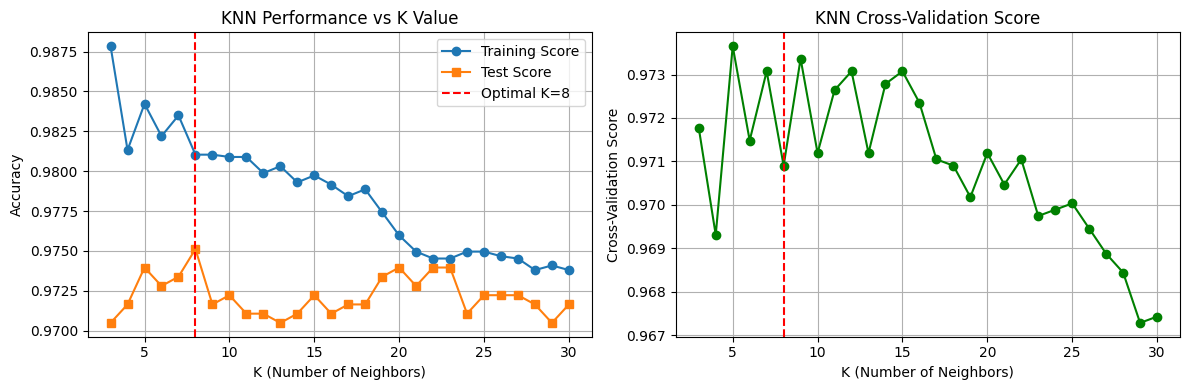

In [13]:
# Visualize K selection
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_values, train_scores, 'o-', label='Training Score')
plt.plot(k_values, test_scores, 's-', label='Test Score')
plt.axvline(x=optimal_k_knn, color='r', linestyle='--', label=f'Optimal K={optimal_k_knn}')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN Performance vs K Value')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(k_values, cv_scores, 'o-', color='green')
plt.axvline(x=optimal_k_knn, color='r', linestyle='--')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Cross-Validation Score')
plt.title('KNN Cross-Validation Score')
plt.grid()

plt.tight_layout()
plt.savefig('knn_optimal_k.png', dpi=300, bbox_inches='tight')
print("✓ Plot saved as 'knn_optimal_k.png'")
plt.show()

## Step 6: Train Final KNN Model

In [14]:
# Train final model with optimal K
knn_final = KNeighborsClassifier(n_neighbors=optimal_k_knn)
knn_final.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = knn_final.predict(X_train_scaled)
y_test_pred = knn_final.predict(X_test_scaled)

print(f"Training Accuracy: {knn_final.score(X_train_scaled, y_train):.4f}")
print(f"Test Accuracy: {knn_final.score(X_test_scaled, y_test):.4f}")

Training Accuracy: 0.9810
Test Accuracy: 0.9751


## Step 7: Evaluate Performance

In [15]:
# Classification Report
print("=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
print("\n" + "=" * 50)
print("CONFUSION MATRIX")
print("=" * 50)
print(confusion_matrix(y_test, y_test_pred))

# Overall Accuracy
print(f"\nOverall Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       897
           1       0.99      0.96      0.97       831

    accuracy                           0.98      1728
   macro avg       0.98      0.97      0.98      1728
weighted avg       0.98      0.98      0.98      1728


CONFUSION MATRIX
[[887  10]
 [ 33 798]]

Overall Accuracy: 0.9751


## Step 8: Analyze Segments and Make Predictions

In [16]:
# Analyze each cluster's characteristics
print("=" * 60)
print("CLUSTER ANALYSIS")
print("=" * 60)

for cluster in sorted(clean_ds['Cluster'].unique()):
    cluster_data = clean_ds[clean_ds['Cluster'] == cluster]
    print(f"\n=== Cluster {cluster} ({len(cluster_data)} customers) ===")
    print(f"Average Balance: ${cluster_data['BALANCE'].mean():,.2f}")
    print(f"Average Purchases: ${cluster_data['TOTAL_PURCHASES'].mean():,.2f}")
    print(f"Payment Ratio: {cluster_data['PAYMENT_RATIO'].mean():.2%}")
    print(f"Full Payment Rate: {cluster_data['FULL_PAYMENT_FLAG'].mean():.2%}")

CLUSTER ANALYSIS

=== Cluster 0 (4482 customers) ===
Average Balance: $2,040.69
Average Purchases: $303.09
Payment Ratio: 49.40%
Full Payment Rate: 0.76%

=== Cluster 1 (4154 customers) ===
Average Balance: $1,127.05
Average Purchases: $1,805.46
Payment Ratio: 48.71%
Full Payment Rate: 16.56%


In [17]:
# Predict segment for a sample customer
print("\n" + "=" * 60)
print("PREDICTING SEGMENT FOR NEW CUSTOMER")
print("=" * 60)

# Take first customer as example
sample_customer = X_knn.iloc[0:1]
sample_customer_scaled = scaler_knn.transform(sample_customer)
predicted_segment = knn_final.predict(sample_customer_scaled)[0]

print(f"\nSample Customer Features (first 5):")
print(sample_customer.iloc[0, :5])
print(f"\nPredicted Segment: Cluster {predicted_segment}")

print("\n" + "=" * 60)
print("PIPELINE COMPLETE!")
print("=" * 60)


PREDICTING SEGMENT FOR NEW CUSTOMER

Sample Customer Features (first 5):
BALANCE                   40.900749
BALANCE_FREQUENCY          0.818182
PURCHASES                 95.400000
ONEOFF_PURCHASES           0.000000
INSTALLMENTS_PURCHASES    95.400000
Name: 0, dtype: float64

Predicted Segment: Cluster 0

PIPELINE COMPLETE!
